In [17]:
import os
from torch.utils import data
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from utils import generate_data_list, SdDataset
import timm

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

data_root = "/home/lym/桌面/gzr-lym/dataset"
classes_list = ['0', '1']
model_name = "densenet121"
BATCH_SIZE = 4

# 读取训练数据路径，验证数据路径
train_image_path_list, train_label_list = generate_data_list(data_root, classes_list, mode="train")
val_image_path_list, val_label_list = generate_data_list(data_root, classes_list, mode="test")

train_dataset = SdDataset(train_image_path_list, train_label_list, transform)
val_dataset = SdDataset(val_image_path_list, val_label_list, transform)

train_dl = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)  # 训练集标签
test_dl = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)  # 测试集标签



In [18]:
torch.cuda.empty_cache()

Epoch-1-Batch-5: Train: Loss-0.1739, Accuracy-0.6000
Epoch-1-Batch-10: Train: Loss-0.1644, Accuracy-0.6500
Epoch-1-Batch-15: Train: Loss-0.1655, Accuracy-0.6333
Epoch-1-Batch-20: Train: Loss-0.1644, Accuracy-0.6250
Epoch-1-Batch-25: Train: Loss-0.1630, Accuracy-0.6200
Epoch-1-Batch-30: Train: Loss-0.1558, Accuracy-0.6500
Epoch-1-Batch-35: Train: Loss-0.1521, Accuracy-0.6643
Epoch-1-Batch-40: Train: Loss-0.1538, Accuracy-0.6687
Epoch-1-Batch-45: Train: Loss-0.1468, Accuracy-0.7000
Epoch-1-Batch-50: Train: Loss-0.1451, Accuracy-0.7100
Epoch-1-Test Accurancy: 0.773 

Saving..
Epoch-2-Batch-5: Train: Loss-0.1283, Accuracy-0.7000
Epoch-2-Batch-10: Train: Loss-0.1203, Accuracy-0.7500
Epoch-2-Batch-15: Train: Loss-0.1239, Accuracy-0.7500
Epoch-2-Batch-20: Train: Loss-0.1234, Accuracy-0.7500
Epoch-2-Batch-25: Train: Loss-0.1194, Accuracy-0.8000
Epoch-2-Batch-30: Train: Loss-0.1228, Accuracy-0.7750
Epoch-2-Batch-35: Train: Loss-0.1226, Accuracy-0.7786
Epoch-2-Batch-40: Train: Loss-0.1250, Accur

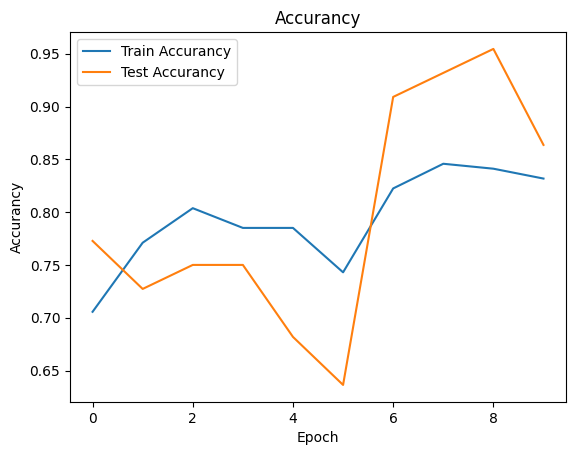

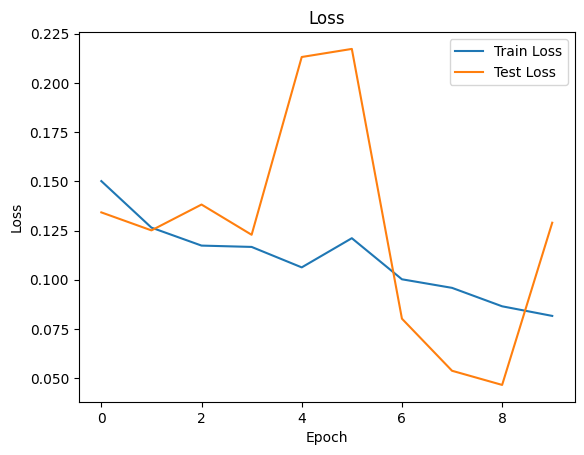

In [19]:
# 判断是否使用GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = timm.create_model(model_name="densenet121", num_classes=2)

model = model_ft.to(DEVICE)  # 将模型迁移到gpu

# 优化器
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(DEVICE)  # 将loss_fn迁移到GPU
# Adam损失函数
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir=os.path.join('checkpoint', model_name, 'tf_logs'))

def train(epoch):
    model.train()
    correct = 0
    total = 0
    train_acc = 0
    train_loss = 0
    total_loss = 0
    # 开始迭代每个batch中的数据
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        # 计算损失
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # 计算准确率
        train_acc = correct / total
        train_loss = total_loss / total
        # 每训练100个batch打印一次训练集的loss和准确率
        if (batch_idx + 1) % 5 == 0:
            print('Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}'.format(epoch + 1,
                                                                                  batch_idx + 1,
                                                                                  train_loss,
                                                                                  train_acc))

    # 计算每个epoch内训练集的acc
    total_train_acc.append(train_acc), total_train_loss.append(train_loss)
    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Accuracy', train_acc, epoch)


# Testing
def test(epoch, ckpt):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_acc = 0
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            test_acc = correct / total
            test_loss = total_loss / total
        print(
            'Epoch-{}-Test Accurancy: {:.3f}'.format(epoch + 1, test_acc), '\n')

    total_test_acc.append(test_acc), total_test_loss.append(test_loss)
    writer.add_scalar('Test/Loss', test_loss, epoch)
    writer.add_scalar('Test/Accuracy', test_acc, epoch)

    # 保存权重文件
    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving..')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        if not os.path.isdir(os.path.join('checkpoint', model_name)):
            os.mkdir(os.path.join('checkpoint', model_name))
        torch.save(model, os.path.join('checkpoint', model_name, model_name + "_" + ckpt))
        best_acc = acc


total_test_acc = []
total_train_acc = []
total_test_loss = []
total_train_loss = []
# 开始训练
epoch = 10
best_acc = 0
for epoch in range(epoch):
    train(epoch)
    test(epoch, "best.pth")
    # 动态调整学习率
    optimizer.step()

writer.close()
plt.figure()
plt.plot(range(epoch + 1), total_train_acc, label='Train Accurancy')
plt.plot(range(epoch + 1), total_test_acc, label='Test Accurancy')
plt.xlabel('Epoch')
plt.ylabel('Accurancy')
plt.title('Accurancy')
plt.legend()
plt.savefig(os.path.join('checkpoint', model_name, f'{model_name}_Accurancy.jpg'))  # 自动保存plot出来的图片

plt.figure()
plt.plot(range(epoch + 1), total_train_loss, label='Train Loss')
plt.plot(range(epoch + 1), total_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.savefig(os.path.join('checkpoint', model_name, f'{model_name}_Loss.jpg'))  # 自动保存plot出来的图片

# 输出best_acc
print(f'Best Acc: {best_acc}%')


In [20]:
#验证

In [21]:
import os
import torch
from PIL import Image
from torch import nn
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])
model = torch.load("/home/lym/桌面/gzr-lym/checkpoint/densenet121/densenet121_best.pth", map_location=torch.device("cpu"))

In [22]:
image = Image.open('/home/lym/桌面/gzr-lym/dataset/test/1/chengjinghui-deep-slice001.jpg')
image = image.convert('RGB')
image = transform(image)
image = torch.reshape(image, (1, 3, 224, 224)) 

In [23]:
output=model(image)
output

tensor([[0.1156, 0.1811]], grad_fn=<AddmmBackward0>)

In [24]:
int(output.argmax(1))

1

In [25]:
i = 0  # 识别图片计数
# 这里最好新建一个test_data文件随机放一些上面整理好的图片进去
root_path = "/home/lym/桌面/gzr-lym/dataset/train"  # 待测试文件夹
names = os.listdir(root_path)

label_train = []
pred_train = []
data_class = ['0', '1']  # 按文件索引顺序排列
for classes in data_class:
    file_list = os.listdir(os.path.join(root_path, classes))
    for file in file_list:
        image_path = os.path.join(root_path, classes, file)
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = transform(image)
        image = torch.reshape(image, (1, 3, 224, 224))  # 修改待预测图片尺寸，需要与训练时一致
        model.eval()
        with torch.no_grad():
            output = model(image)
        # print(int(output.argmax(1)))
        # 对结果进行处理，使直接显示出预测的种类
        pred_train.append(int(output.argmax(1))) #output.argmax(1)
        label_train.append(int(classes))
        # print("名字：{} 图片预测为：{}".format(os.path.join(root_path, classes, file), data_class[int(output.argmax(1))]))


print(label_train)
print(pred_train)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
i = 0  # 识别图片计数
# 这里最好新建一个test_data文件随机放一些上面整理好的图片进去
root_path = "/home/lym/桌面/gzr-lym/dataset/test"  # 待测试文件夹
names = os.listdir(root_path)

label_test = []
pred_test = []
data_class = ['0', '1']  # 按文件索引顺序排列
for classes in data_class:
    file_list = os.listdir(os.path.join(root_path, classes))
    for file in file_list:
        image_path = os.path.join(root_path, classes, file)
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = transform(image)
        image = torch.reshape(image, (1, 3, 224, 224))  # 修改待预测图片尺寸，需要与训练时一致
        model.eval()
        with torch.no_grad():
            output = model(image)
        # print(int(output.argmax(1)))
        # 对结果进行处理，使直接显示出预测的种类
        pred_test.append(int(output.argmax(1))) #output.argmax(1)
        label_test.append(int(classes))
        # print("名字：{} 图片预测为：{}".format(os.path.join(root_path, classes, file), data_class[int(output.argmax(1))]))


print(label_test)
print(pred_test)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

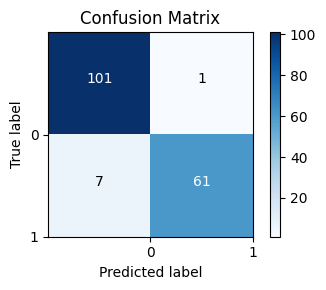

In [28]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(label_train, pred_train)
# 绘制混淆矩阵图
plt.figure(figsize=(4, 3))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['0', '1']
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [29]:
# 保存混淆矩阵图
#plt.savefig('swin_transformer_confusion_matrix.png')

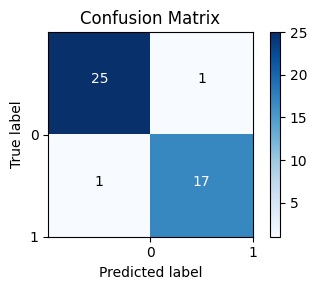

In [30]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(label_test, pred_test)
# 绘制混淆矩阵图
plt.figure(figsize=(4, 3))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['0', '1']
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [31]:
# 保存混淆矩阵图
#plt.savefig('swin_transformer_confusion_matrix.png')

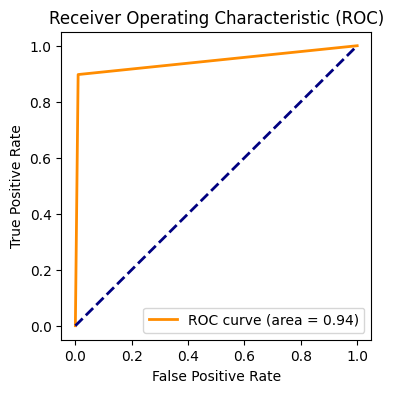

In [32]:
# 计算ROC曲线和AUC值
fpr, tpr, _ = roc_curve(label_train, pred_train)
roc_auc = auc(fpr, tpr)

# 绘制AUC图
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# 显示图形
plt.show()
# 保存AUC图
#plt.savefig('swin_transformer_auc_curve.png')

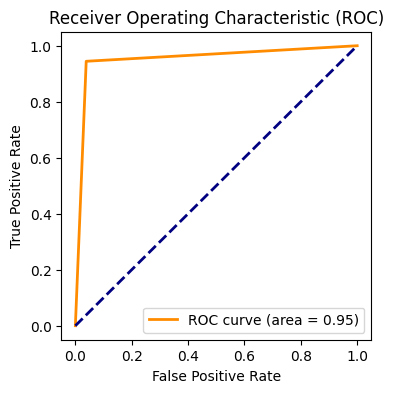

In [33]:
# 计算ROC曲线和AUC值
fpr, tpr, _ = roc_curve(label_test, pred_test)
roc_auc = auc(fpr, tpr)

# 绘制AUC图
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
# 显示图形
plt.show()
# 保存AUC图
#plt.savefig('swin_transformer_auc_curve.png')